# PyTorch Cats and Dogs Classifier

## Import the modules we need

In [2]:

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

### Load the the training and test dataset from the folder, resize the image size, Crop it and make data augmentation


In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([
            transforms.Resize(256),transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])
test_transforms = transforms.Compose([
            transforms.Resize(256),transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)



## Split the training dataset into training set and validation set

In [4]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Display random images from the training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


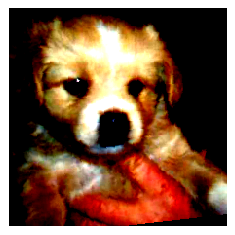

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
# Run this to test your data loader
train_images, train_labels = next(iter(train_dataloader))
print(train_images.shape)
imshow(train_images[0], normalize=False)

## Build Network Architectures of our model

##### In this project 3 convolutional layers,2x2 MaxPool pooling method and 3 multilayer perceptron hidden layers are used. The Dropout % is 30. We use Adam optimizer and for loss calculation we use NLLLoss(). We use learning rate 0.001.


In [5]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutions
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        # Max-pool
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256*7*7,1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)
        #self.fc4 = nn.Linear(1024, 512)
        #self.fc5 = nn.Linear(512, 2)
        # Dropout module with 0.3 drop probability
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # make sure input tensor is flattened
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1,256*7*7)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        #x = self.dropout(F.relu(self.fc4(x)))
        # output so no dropout here
        x = F.log_softmax(self.fc3(x),dim=1)

        return x
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Testing

##### Train the model using the training set and pass the the validation set through the network in forward propagation and calculate the loss. After completing the training and testing the model will be saved for later use. The model will be saved on the epoch if the validation loss is decreased.

In [7]:
print('loading...')
epochs = 15
steps = 0

train_losses, valid_losses = [], []
valid_loss_min = np.Inf # set initial "min" to infinity
for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        model.train() 
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        #for calculating the accuracy of training set
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        
        
        # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval() 
        for data, target in valid_loader:
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}\tTrain Accuracy: {:.3f} \tValidation Loss: {:.6f}'.format(
            e+1, 
            train_loss,
            train_accuracy/len(train_dataloader),
            valid_loss
            ))
    model.train() 
            # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model1.pt')
        valid_loss_min = valid_loss
           

loading...
Epoch: 1 	Training Loss: 0.534838	Train Accuracy: 0.576 	Validation Loss: 0.125647
Validation loss decreased (inf --> 0.125647).  Saving model ...
Epoch: 2 	Training Loss: 0.447658	Train Accuracy: 0.714 	Validation Loss: 0.100410
Validation loss decreased (0.125647 --> 0.100410).  Saving model ...
Epoch: 3 	Training Loss: 0.385114	Train Accuracy: 0.774 	Validation Loss: 0.091806
Validation loss decreased (0.100410 --> 0.091806).  Saving model ...
Epoch: 4 	Training Loss: 0.324478	Train Accuracy: 0.818 	Validation Loss: 0.074449
Validation loss decreased (0.091806 --> 0.074449).  Saving model ...
Epoch: 5 	Training Loss: 0.283561	Train Accuracy: 0.843 	Validation Loss: 0.071170
Validation loss decreased (0.074449 --> 0.071170).  Saving model ...
Epoch: 6 	Training Loss: 0.242449	Train Accuracy: 0.871 	Validation Loss: 0.055725
Validation loss decreased (0.071170 --> 0.055725).  Saving model ...
Epoch: 7 	Training Loss: 0.215069	Train Accuracy: 0.886 	Validation Loss: 0.055726

### Draw the graph of train loss and Validation loss for checking Overfitting

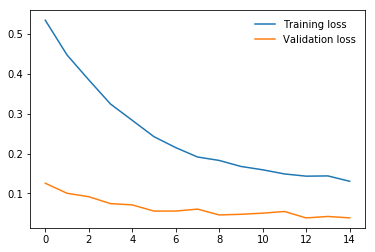

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Load the saved model

In [6]:
model.load_state_dict(torch.load('model1.pt'))

## Test the model on new unseen data

In [10]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.206479

Test Accuracy of     0: 93% (1164/1250)
Test Accuracy of     1: 90% (1130/1250)

Test Accuracy (Overall): 91% (2294/2500)
